#  Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Model , layers, Sequential
import keras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset


In [5]:
def unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(p4)
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(bn)

    # Decoder
    # u1 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding="same")(bn)
    # u1 = layers.concatenate([u1, c4])
    # c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(u1)
    # c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(c5)

    # u2 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding="same")(c5)
    # u2 = layers.concatenate([u2, c3])
    # c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(u2)
    # c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(c6)

    # u3 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding="same")(c6)
    # u3 = layers.concatenate([u3, c2])
    # c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(u3)
    # c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(c7)

    # u4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(c7)
    # u4 = layers.concatenate([u4, c1])
    # c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(u4)
    # c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(c8)

    # Output: 3-channel RGB image with sigmoid (for [0,1] range)

    x = layers.GlobalAveragePooling2D()(bn)
    # x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(29, activation="sigmoid")(x)

    return Model(inputs, outputs, name="U-Net_Colorization")


model = unet((128, 128, 3))
model.summary()

Model: "U-Net_Colorization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 128)       147584    
                                                

In [7]:
import tensorflow as tf

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/train',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)



test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/test',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/val',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)


normalization_layer = tf.keras.layers.Rescaling(1./255)


# Normalización
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)



# Tamaño del dataset
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Validation size: {val_size}")


Found 20300 files belonging to 29 classes.
Found 5800 files belonging to 29 classes.
Found 2900 files belonging to 29 classes.
Train size: 318
Test size: 91
Validation size: 46


In [8]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='best_modelUnet.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2, min_lr=1e-6),
]


history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
318/318 [==============================] - 120s 231ms/step - loss: 3.1445 - accuracy: 0.2057 - val_loss: 3.2685 - val_accuracy: 0.2521 - lr: 1.0000e-04
Epoch 2/50
318/318 [==============================] - 83s 216ms/step - loss: 2.4890 - accuracy: 0.3297 - val_loss: 2.3532 - val_accuracy: 0.3845 - lr: 1.0000e-04
Epoch 3/50
318/318 [==============================] - 85s 230ms/step - loss: 2.1875 - accuracy: 0.4107 - val_loss: 1.9996 - val_accuracy: 0.4703 - lr: 1.0000e-04
Epoch 4/50
318/318 [==============================] - 79s 214ms/step - loss: 1.9794 - accuracy: 0.4706 - val_loss: 1.8991 - val_accuracy: 0.5052 - lr: 1.0000e-04
Epoch 5/50
318/318 [==============================] - 76s 205ms/step - loss: 1.7830 - accuracy: 0.5212 - val_loss: 1.6992 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 6/50
318/318 [==============================] - 72s 194ms/step - loss: 1.5910 - accuracy: 0.5801 - val_loss: 1.6368 - val_accuracy: 0.5690 - lr: 1.0000e-04
Epoch 7/50
318/318 [=======

<Figure size 1200x600 with 0 Axes>

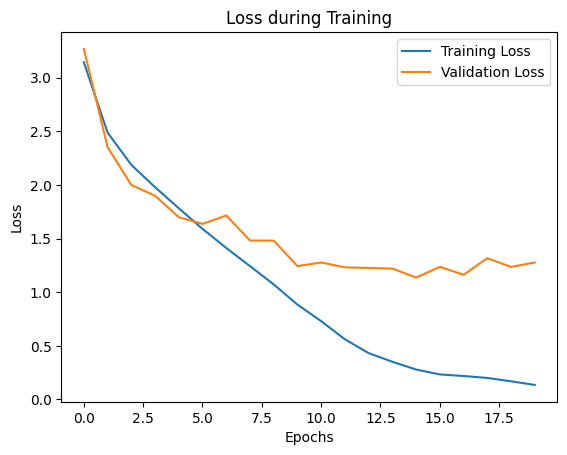

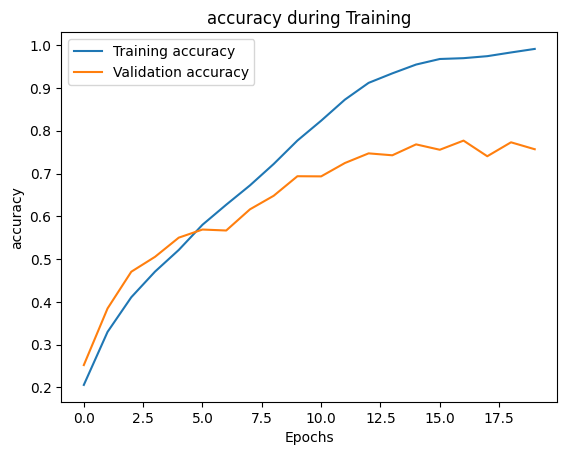

In [9]:
plt.figure(figsize=(12, 6))

# Pérdida
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# PSNR
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


2/2 [==============================] - 0s 34ms/step
Accuracy de validación: 0.79


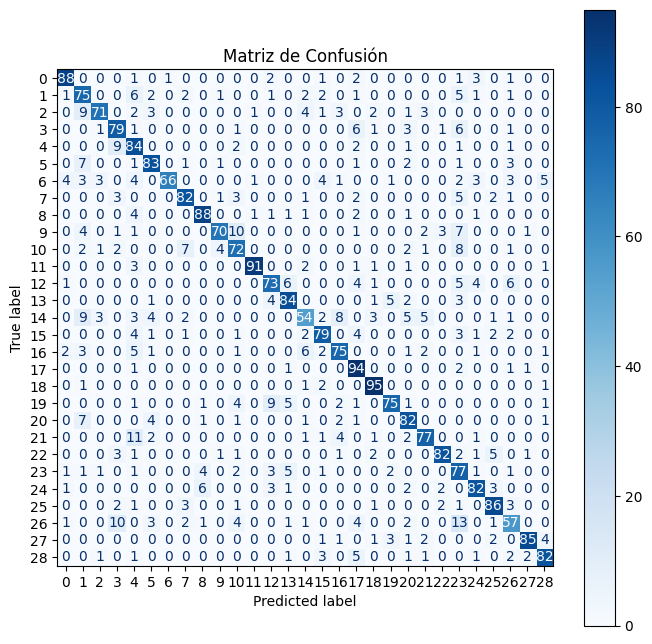

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import keras
#load the best model
# load
unet_clas = keras.models.load_model("best_modelUnet.h5")
# Load the best model with custom objects
# model_ = keras.models.load_model("best_modelV5.h5", custom_objects={"TFViTMAEMainLayer": TFViTMAEMainLayer})
# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = unet_clas.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
# elmina la etiqueta 3
# y_true = [label for label in y_true if label != 3]
# y_pred = [pred for pred, label in zip(y_pred, y_true) if label != 3]
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title("Matriz de Confusión")
plt.show()

2/2 [==============================] - 0s 13ms/step


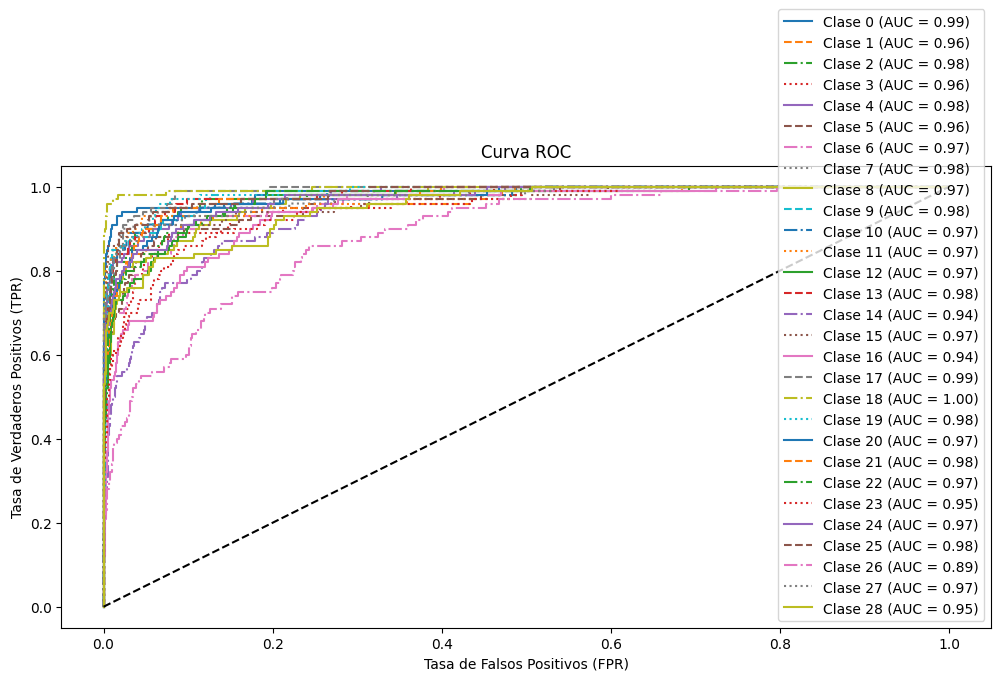

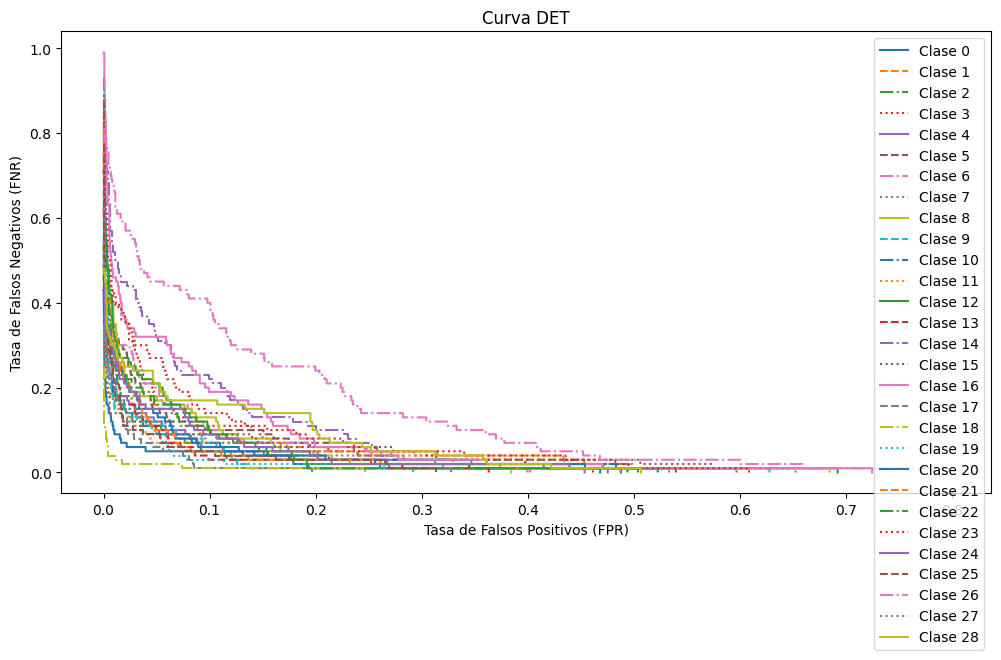

In [70]:
from sklearn.metrics import roc_curve, det_curve, auc

import matplotlib.pyplot as plt

# Convertir y_true y y_pred a formato binario para cada clase
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = unet_clas.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true_binary = keras.utils.to_categorical(y_true, num_classes=29)
y_pred_binary = np.array(y_pred)

# Generar la curva ROC y calcular el AUC para cada clase
plt.figure(figsize=(12, 6))
line_styles = ['-', '--', '-.', ':']  # Diferentes estilos de línea
for i in range(29):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})', linestyle=line_styles[i % len(line_styles)])

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva DET para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    # Verificar si hay más de una clase en y_true_binary[:, i]
    if len(np.unique(y_true_binary[:, i])) > 1:
        fpr, fnr, _ = det_curve(y_true_binary[:, i], y_pred_binary[:, i])
        plt.plot(fpr, fnr, label=f'Clase {i}', linestyle=line_styles[i % len(line_styles)])
    else:
        print(f"Clase {i} tiene solo una clase en y_true. No se puede generar la curva DET.")

plt.title('Curva DET')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Falsos Negativos (FNR)')
plt.legend(loc='upper right')
plt.show()